In [68]:
import sys
import os
import numpy as np
from osgeo import ogr 
from collections import deque
import matplotlib.pyplot as plt
import csv
from scipy.ndimage import median_filter



sys.path.append("/home/riannek/code/gleis/gleisachse")
from algs.gpkg import * 
from algs.growingline import *

ogr.UseExceptions()

In [69]:
ds = None

In [70]:
layer_name = "central_points"

folder = "/media/riannek/minimax/gleis/"

ds = None 

import shutil 
file = shutil.copyfile(os.path.join(folder, "stage3vers.gpkg"), os.path.join(folder, "stage3tmp.gpkg")) # src, dst

ds = ogr.Open(file, 1)

layers = []
for i in range(ds.GetLayerCount()):
    layer = ds.GetLayer(i)
    layers.append(layer.GetName())
layers.sort()
print(layers)

layer = ds.GetLayerByName(layer_name)

['abseits', 'anfang weiche', 'central_points', 'kurve', 'needsfilter', 'templinelayer', 'viele', 'viele1', 'weiche', 'weiche2']


In [71]:
# Remove skip field if it exists
field_index = layer.GetLayerDefn().GetFieldIndex("skip")
if field_index >= 0:
    layer.DeleteField(field_index)

# Add "skip" field 
field = ogr.FieldDefn("skip", ogr.OFTInteger)
layer.CreateField(field)

0

In [72]:
report = "report_run24.csv"
exists = os.path.exists(report)

In [73]:
report_file = open(report, "a")
writer = csv.writer(report_file)
if not exists: 
    writer.writerow(["layer", "points", "mean", "std", "min", "max", "used"])


In [74]:
linelayer = new_line_layer(ds, layer.GetSpatialRef(), None)
switchlayer = new_switch_layer(ds, layer.GetSpatialRef(), None)

In [75]:
queue = deque()

In [76]:

layer.GetFeatureCount()

339210

In [77]:
dist_list = []

## Schleife

In [78]:
while layer.GetFeatureCount() > 0:
    # print("feature count:", layer.GetFeatureCount())
    
    layer.SetAttributeFilter("skip IS NULL")
    feature = layer.GetNextFeature()
    layer.SetAttributeFilter(None)
    if feature is None:
        break
    active_line = GrowingLine.from_feature(feature)

    while True:
        try:
            geom, next_lines = active_line.grow(layer, switchlayer)
        except StartInSwitchError:
            # print("#########")

            # Skip this feature in the next iteration
            feature.SetField("skip", 2)
            layer.SetFeature(feature)
            break

        if geom is not None:
            # used = active_line.used_track() # 1 for used track, 0 otherwise
            # add_to_layer(linelayer, geom, used=used)
            print(f"Added line with {round(geom.Length())} m")
            points = np.array(active_line.points)
            distances = distance_points_to_line(points, points[0], (points[-1] - points[0]))
            rolling_median = median_filter(distances, size=7, mode='reflect')
            distances_corrected = np.abs(distances - rolling_median)
            distances_corrected[0] = 0
            distances_corrected[-1] = 0
            dist_list.append(distances_corrected)
            writer.writerow([
                layer_name,
                len(points),
                np.mean(distances_corrected),
                np.std(distances_corrected),
                np.min(distances_corrected),
                np.max(distances_corrected),
                active_line.used_track()
            ])

        queue.extend(next_lines)
        if len(queue) == 0:
            break
        active_line = queue.popleft()
        print("pop", active_line.head_fid)


Added line with 2321 m
pop 111411
Added line with 727 m
Added line with 2253 m
pop 55747
Added line with 1613 m
pop 8871
Added line with 216 m
pop 257107
Added line with 9359 m
pop 149614
Added line with 210 m
pop 305655
Added line with 4538 m
pop 203077
pop 203355
Added line with 208 m
pop 24924
pop 24910
Added line with 148 m
pop 10180
Added line with 57 m
pop 338287
Added line with 81 m
pop 63279
Added line with 253 m
Added line with 5801 m
pop 33303
Added line with 391 m
Added line with 4510 m
pop 174250
Added line with 113 m
pop 306639
Added line with 46 m
pop 203037
pop 162634
Added line with 3471 m
pop 203074
Added line with 1216 m
pop 219002
pop 218932
Added line with 154 m
pop 54924
Added line with 233 m
Added line with 495 m
pop 87417
Added line with 27 m
pop 15660
Added line with 183 m
pop 213854
Added line with 55 m
pop 148604
Added line with 62 m
pop 309461
Added line with 728 m
Added line with 439 m
pop 250747
Added line with 57 m
pop 87393
pop 87451
Added line with 395 m

In [79]:
ds = None

In [80]:
report_file.close()

In [81]:
np.savez("distances.npz", *dist_list)

## STOP HERE

In [82]:
raise ValueError("Stop here")

ValueError: Stop here

(array([80., 18., 11.,  9.,  8.,  6.,  5.,  4.,  5.,  1.,  2.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  3.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.00014184, 0.00028368, 0.00042551, 0.00056735,
        0.00070919, 0.00085103, 0.00099287, 0.0011347 , 0.00127654,
        0.00141838, 0.00156022, 0.00170206, 0.00184389, 0.00198573,
        0.00212757, 0.00226941, 0.00241125, 0.00255308, 0.00269492,
        0.00283676, 0.0029786 , 0.00312044, 0.00326227, 0.00340411,
        0.00354595, 0.00368779, 0.00382963, 0.00397147, 0.0041133 ,
        0.00425514, 0.0043

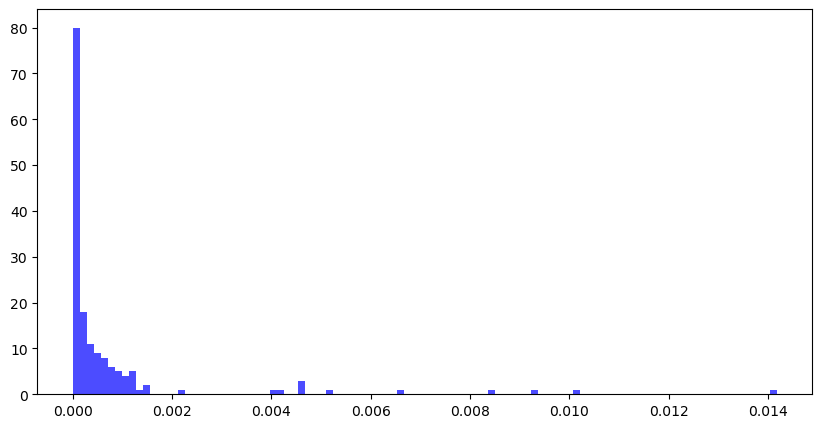

In [ ]:
linedist = dist_list[1]

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(linedist, bins=100, color='blue', alpha=0.7)

In [83]:
linedist 

array([0.00000000e+00, 9.26466911e-03, 1.02093845e-02, 4.09325211e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.09158969e-05, 4.75212766e-04, 1.33578517e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.00326347e-04, 5.49923645e-04, 5.94157285e-05, 2.82714373e-04,
       1.17416793e-03, 8.13970094e-05, 8.13970094e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.65399707e-04, 2.65399707e-04, 2.27458928e-04, 9.23743690e-06,
       2.36696365e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.51437431e-04, 1.51437431e-04, 4.93056000e-05, 0.00000000e+00,
       4.93056000e-05, 3.43228583e-04, 4.77946005e-04, 4.15389174e-04,
       0.00000000e+00, 2.43739977e-04, 4.68121170e-04, 0.00000000e+00,
       6.40604287e-05, 9.02225134e-04, 1.21799943e-03, 8.08860800e-04,
      

In [ ]:
geom = active_line.get_linestring()
print(geom.Length())

if geom.Length() > 5:
    add_to_layer(linelayer, geom)


6.5373792594158795


In [ ]:
layer.SetAttributeFilter(None)
feature = layer.GetFeature(210352)
feature  

In [ ]:
print(len(active_line.switch))

0


In [ ]:
active_line.switch 

[]

In [ ]:
active_line.switch[2].points  

[array([4.47386367e+06, 5.33619907e+06, 5.16786670e+02]),
 array([4.47386389e+06, 5.33619810e+06, 5.16788972e+02]),
 array([4.47386408e+06, 5.33619719e+06, 5.16793189e+02]),
 array([4.47386424e+06, 5.33619647e+06, 5.16796515e+02]),
 array([4.47386439e+06, 5.33619578e+06, 5.16799393e+02]),
 array([4.47386459e+06, 5.33619489e+06, 5.16803550e+02])]

In [ ]:
queue.extend(active_line.switch)
print(len(queue))

1


In [ ]:
active_line = queue.popleft()

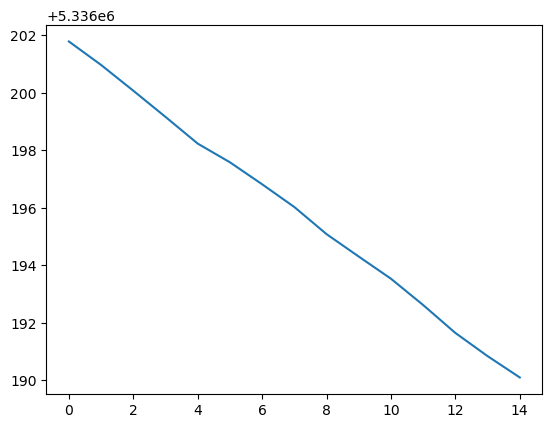

In [ ]:
foo = np.array(active_line.points)
foo = foo[:,1] 
x = np.arange(len(foo))
fig, ax = plt.subplots()
ax.plot(x, foo)

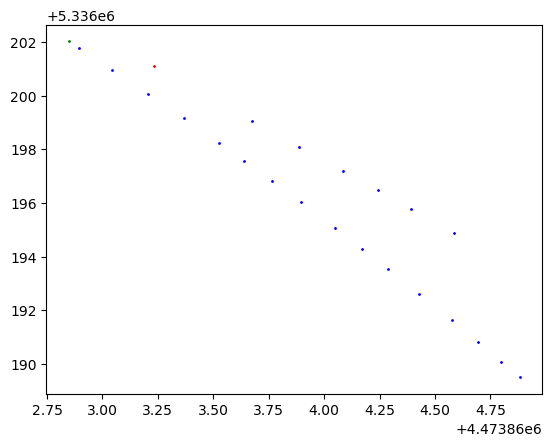

In [ ]:
fig, ax = plt.subplots()
foo = np.array(active_line.points)
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='b', s=1)

foo = np.array(active_line.switch[0].points)  
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='r', s=1)

foo = np.array(active_line.switch[1].points)  
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='g', s=1)

foo = np.array(active_line.switch[2].points)  
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='b', s=1)

TypeError: in method 'Layer_GetFeature', argument 1 of type 'OGRLayerShadow *'

TypeError: in method 'Layer_GetFeatureCount', argument 1 of type 'OGRLayerShadow *'

In [ ]:
geom = ogr.Geometry(ogr.wkbLineString25D)

In [ ]:
geom  

<osgeo.ogr.Geometry; proxy of <Swig Object of type 'OGRGeometryShadow *' at 0x7fc4db40fdb0> >

In [ ]:
foo = np.array(
    [
        [10.0, 10.0, 0.0],
        [20.0, 20.0, 0.0],
        [30.0, 30.0, 0.0],
        [40.0, 40.0, 0.0]
    ]
)

foo

array([[10., 10.,  0.],
       [20., 20.,  0.],
       [30., 30.,  0.],
       [40., 40.,  0.]])

In [ ]:
this_point = foo[:-1]
next_point = np.roll(foo, -1, axis=0)[:-1]

In [ ]:
np.linalg.norm(foo - foo[0], axis=1)

array([ 0.        , 14.14213562, 28.28427125, 42.42640687])